# XGBoost Model for Energy Demand in Spain

## XGBoost

XGBoost (eXtreme Gradient Boosting) is a powerful, scalable machine learning algorithm based on gradient boosting. It builds decision trees sequentially, where each tree corrects the errors of the previous one, optimizing for a custom loss function.

XGBoost can be effectively applied to time series analysis, including energy demand forecasting, by treating the problem as a supervised learning task. Instead of directly modeling the temporal dependencies, XGBoost can leverage lagged features, rolling statistics (e.g., moving averages), and other relevant external factors (e.g. weather or public holidays) as input features. Its flexibility and ability to handle nonlinear relationships make it well-suited for energy demand forecasting.

## Multi-Output XGBoost

The model needs to be able to make 24 hourly predictions for the following day at noon. This can be achieved using:
- **Multi-output regression** : model directly outputs a 24-vector of predictions
    - Pros : Captures global hour-to-hour dependencies with a single, fast model.
    - Cons : High complexity due to 24-dimensional output and struggles with hour-specific nuances.
- **One model per hour** : 24 different models, one for each hour
    - Pros : Specializes in hour-specific patterns, improving accuracy.
    - Cons : Computationally expensive and lacks inter-hour dependency learning.
- **Recursive Autoregressive Approach** : predict one hour at a time, feeding predictions back as inputs for future hours
    - Pros : Captures sequential dependencies dynamically with a single model.
    - Cons : Errors compound over time, potentially degrading later predictions.

Therefore, a multi-output regression model will be used as it is crucial to be able to capture inter-hour dependencies (unlike one model per hour) and the compounding errors of the recursive autoregressive approach will become too large since 36 time steps are needed to be predicted.

## Data Exploration

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import geopandas as gpd
import matplotlib.patches as mpatches
import shapely.geometry

In [15]:
df = pd.read_csv('weather_data_madrid.csv')
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df.set_index('datetime', inplace=True)

df.describe()

,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk
count,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20250.000000,20400.000000,20399.000000,20400.000000,20400.000000,20400.000000,20400.000000,20399.000000,20400.000000,20400.000000,20400.000000,0.0
mean,14.469147,13.923387,5.419912,59.998705,0.066750,8.794118,0.001828,0.133541,16.599882,8.743127,180.623132,1018.230956,43.246373,16.230889,168.878319,0.607946,1.670637,NaN
std,8.387311,8.563601,5.024033,22.241893,0.627145,28.321627,0.123635,1.206195,12.500490,6.366873,112.677002,6.939307,36.533063,6.187406,246.811956,0.889143,2.481976,NaN
min,-9.200000,-9.200000,-14.500000,7.810000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,991.200000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,8.500000,7.400000,2.000000,42.137500,0.000000,0.000000,0.000000,0.000000,8.300000,4.200000,64.000000,1013.400000,3.300000,13.200000,0.000000,0.000000,0.000000,NaN
50%,12.700000,12.700000,5.800000,60.750000,0.000000,0.000000,0.000000,0.000000,13.700000,7.100000,207.000000,1017.600000,40.000000,14.900000,12.000000,0.000000,0.000000,NaN
75%,20.000000,20.000000,9.100000,78.830000,0.000000,0.000000,0.000000,0.000000,22.000000,11.600000,270.000000,1023.000000,80.000000,16.900000,302.000000,1.100000,3.000000,NaN
max,41.300000,39.200000,20.200000,100.000000,33.155000,100.000000,17.210000,18.700000,177.700000,55.600000,360.000000,1037.200000,100.000000,40.600000,1138.000000,4.100000,10.000000,NaN


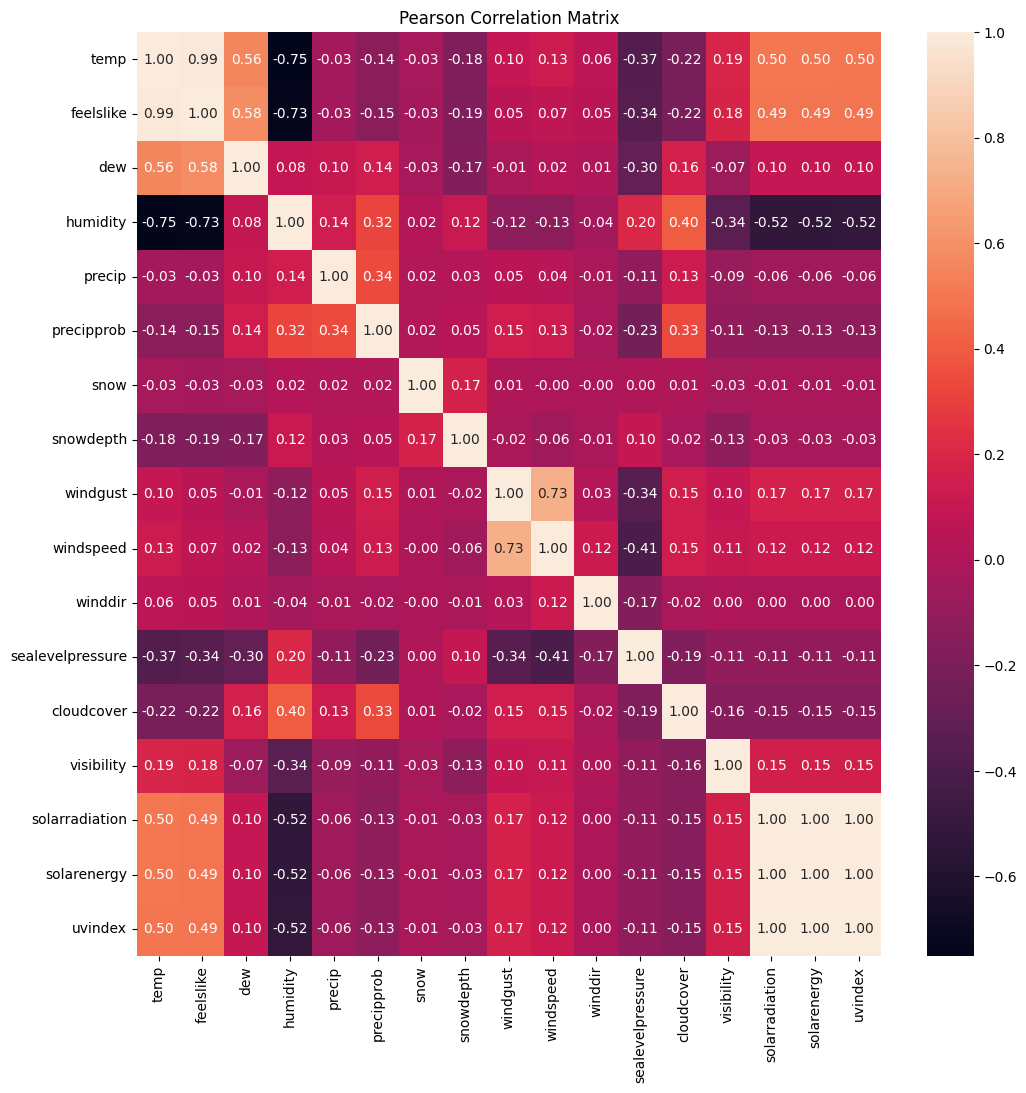

In [14]:
df_weather = df.drop(['name', 'preciptype', 'severerisk', 'conditions', 'icon', 'stations'], axis=1)

correlations = df_weather.corr(method='pearson')
fig = plt.figure(figsize=(12, 12))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

Based on correlation matrix:
 - Can drop solar energy and uv index and just keep solar radiation as they're perfectly correlated
 - Can drop feels like as almost perfectly correlated with temp, or can create a feel vs actual difference feature
 - Can drop wind gust as it is highly correlated with wind speed

In [16]:
print('There are {} missing values or NaNs in df_final.'
      .format(df_weather.isnull().values.sum()))

There are 152 missing values or NaNs in df_final.


## Feature Engineering

To ensure robust model training, we follow the general rule of having at least 10 times more data points than features. Since a multi-output regression model has been chosen, each data point now represents a full day instead of a single hour. This reduces the number of data points by a factor of 24 while simultaneously increasing the number of features by a factor of 24.

The training dataset consists of 1,461 days. To maintain a 10:1 ratio of data points to features, we can use a maximum of 146 features.

With weather data for five cities, using the temperature for the last 24 hours from each city already accounts for 120 features. This leaves insufficient room for other critical features, such as previous demand values, time-based features (e.g., month, day of the week), or additional weather parameters.

To address this, a weighted average of the weather data from the five cities will be used instead of individual city data. The weights will be based on the population living closest to each city. A Voronoi diagram will be created with nodes at the cities to determine the populations within each city’s region.

This approach will include populations in Ceuta, Melilla, and the Balearic Islands, as they are connected to the Spanish electricity grid via submarine cables. However, it will exclude the Canary Islands, as their electrical grid operates independently.

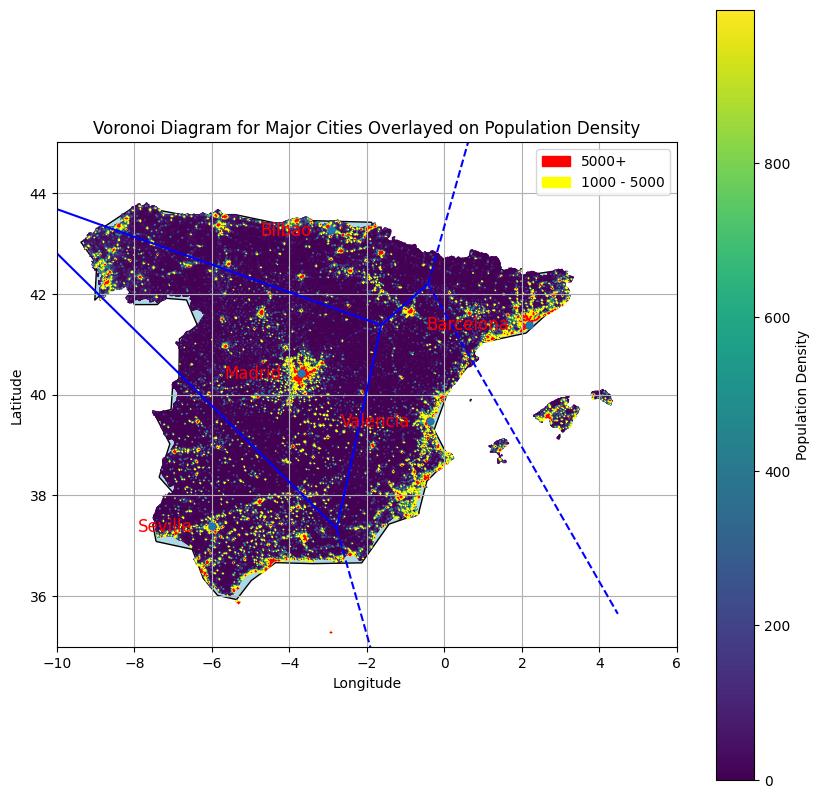

In [ ]:
# Load the CSV file of population density data
df = pd.read_csv('data/population_density.csv')
df = df[(df['Y'] > 34)]

df_mid = df[(df['Z'] < 1000)]
df_large = df[(df['Z'] >= 1000) & (df['Z'] < 5000)]
df_xlarge = df[(df['Z'] >= 5000)]

df_mid = df_mid.sort_values(by='Z', ascending=True)

# Read the shapefile for world countries
shapefile_path = 'data/country_shapes/ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)

# Filter for Spain
spain = world[world['NAME'] == 'Spain']

# Define the coordinates of the 5 major cities
major_cities = {
    'Madrid': (-3.7033, 40.4169),
    'Barcelona': (2.1769, 41.3828),
    'Valencia': (-0.3764, 39.4700),
    'Seville': (-5.9900, 37.3900),
    'Bilbao': (-2.9236, 43.2569)
}
city_coords = np.array(list(major_cities.values()))

vor = Voronoi(city_coords)


fig, ax = plt.subplots(figsize=(10, 10))

spain.plot(ax=ax, color='lightblue', edgecolor='black')

# Add scatter plot with population density values as z-axis
scatter = ax.scatter(df_mid['X'], df_mid['Y'], c=df_mid['Z'], cmap='viridis', s=1, edgecolor='k' , linewidth=0)
scatter2 = ax.scatter(df_large['X'], df_large['Y'], c='yellow', s=1, edgecolor='k' , linewidth=0)
scatter3 = ax.scatter(df_xlarge['X'], df_xlarge['Y'], c='red', s=1, edgecolor='k' , linewidth=0)

# Add a colorbar
plt.colorbar(scatter, ax=ax, label='Population Density')

# Create custom legend labels for yellow and red
yellow_patch = mpatches.Patch(color='yellow', label='1000 - 5000')
red_patch = mpatches.Patch(color='red', label='5000+')
plt.legend(handles=[red_patch, yellow_patch], loc='upper right')

voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='blue', line_width=1.5, point_size=10)

# Annotate the cities
for city, coord in major_cities.items():
    ax.text(coord[0] - 0.5, coord[1] - 0.1, city, fontsize=12, ha='right', color='red')

ax.set_xlim(-10, 6)  # Spain's longitude range
ax.set_ylim(35, 45)  # Spain's latitude range

# Show the plot
plt.title("Voronoi Diagram for Major Cities Overlayed on Population Density")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

The graph above shows how spain will be split, overlayed on the population density. Since each of the data points covers a 1km x 1km square, can use the population densities to calculate the populations within each region. These can then be normalised to sum to 1.

In [11]:
# Create a rectangle surrounding spain then a large rectangle surrounding it
polygon = shapely.wkt.loads('Polygon ((-10 35, -10 45, 6 45, 6 35, -10 35)))')
bound = polygon.buffer(20).envelope.boundary 

# Create many points along the rectangle boundary so Voroni regions don't go to infinity
boundarypoints = [bound.interpolate(distance=d) for d in range(0, np.ceil(bound.length).astype(int), 4)]
boundarycoords = np.array([[p.x, p.y] for p in boundarypoints])

#Create an array of all points on the boundary and inside the polygon
all_coords = np.concatenate((boundarycoords, city_coords)) 

vor = Voronoi(all_coords)

lines = [shapely.geometry.LineString(vor.vertices[line]) for line in 
    vor.ridge_vertices if -1 not in line]

polys = shapely.ops.polygonize(lines)
voronois = gpd.GeoDataFrame(geometry=gpd.GeoSeries(polys), crs="epsg:3006")

polydf = gpd.GeoDataFrame(geometry=[polygon], crs="epsg:3006")
points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=city_coords[:,0], y=city_coords[:,1], crs="epsg:3006"))

result = gpd.overlay(df1=voronois, df2=polydf, how="intersection")
result['region_id'] = range(len(result))
city_labels = {
    3: 'Madrid',
    0: 'Barcelona',
    2: 'Valencia',
    4: 'Seville',
    1: 'Bilbao'
}

# Add a column for city labels based on region ID
result['city'] = result['region_id'].map(city_labels)

population_gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df['X'], df['Y']), crs='epsg:3006'
)

# Perform spatial join
population_gdf = gpd.sjoin(population_gdf, result, how='inner', predicate='within')

# Sum population density within each Voronoi region
population_sum = population_gdf.groupby('city')['Z'].sum()

# Normalize so that the total population density sums to 1
population_sum_normalized = population_sum / population_sum.sum()

print(population_sum_normalized)

city
Barcelona    0.202184
Bilbao       0.141825
Madrid       0.269779
Seville      0.186186
Valencia     0.200026
Name: Z, dtype: float64
